# 캐글 경진대회  
# eda로 성능 올리기?

# EDA란?
##### 1) 정의  
수집한 데이터가 들어왔을 때, 이를 다양한 각도에서 관찰하고 이해하는 과정입니다. 한마디로 데이터를 분석하기 전에 그래프나 통계적인 방법으로 자료를 직관적으로 바라보는 과정입니다.

##### 2) 필요한 이유  
데이터의 분포 및 값을 검토함으로써 데이터가 표현하는 현상을 더 잘 이해하고, 데이터에 대한 잠재적인 문제를 발견할 수 있습니다. 이를 통해, 본격적인 분석에 들어가기에 앞서 데이터의 수집을 결정할 수 있습니다.

다양한 각도에서 살펴보는 과정을 통해 문제 정의 단계에서 미쳐 발생하지 못했을 다양한 패턴을 발견하고, 이를 바탕으로 기존의 가설을 수정하거나 새로운 가설을 세울 수 있습니다.

In [1]:
# 전체 코드를 실행시키는 데에 필요한 모든 라이브러리를 한 번에 가져옴

import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

print("실행함")

실행함


In [2]:
# lms에서 추가한거. 시각화

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

print("실행함")

실행함


In [3]:
# lms 실행에 맞게 경로 변경

data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
sub_data_path = join(data_dir, 'test.csv')      # 테스트, 즉 submission 시 사용할 데이터 경로

print("실행함")

실행함


In [4]:
# 데이터를 변수 data, sub로 불러오기

data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)
print('train data dim : {}'.format(data.shape))
data.columns

train data dim : (15035, 21)


Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [5]:
print('sub data dim : {}'.format(sub.shape))
sub.columns
# 테스트 데이터라 가격이 없다

sub data dim : (6468, 20)


Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [6]:
# 학습 데이터에서 라벨 제거
# price 컬럼을 y에 저장하고 data에서는 price 칼럼을 지워줌

y = data['price']

del data['price']
print("실행함")

실행함


In [7]:
# 학습 데이터와 테스트 데이터 합치기
# 모델을 학습시키기 전에, 전체 데이터에 대해 탐색해보기 위해 두 데이터를 pd.concat으로 합침
# 학습을 진행할 때에는 다시 분리해서 사용해야 하기 때문에 데이터를 합치기 전 train_len에 training data의 개수를 저장.
# 추후에 학습데이터만 불러올 수 있는 인덱스로 사용

train_len = len(data)
data = pd.concat((data, sub), axis=0)
print(train_len)
print(len(data))
# 트레인렌에 저장 이후에 합쳐서 두개가 다름

15035
21503


학습데이터에서 가격을 지우는 코드를 이 곳에 넣었더니 오루가 났다.  
학습에서 x의 데이터 수와 y의 데이터 수가 같지 않았기 때문으로 보인다.  
즉 여기에서 y를 할당하면 테스트의 빈 가격 정보까지 저장되기 때문에 21503개가 되니까...

In [8]:
# 필요 없는 id 컬럼 제거. 나중에 예측 결과를 제출할 때를 대비하여 sub_id 변수에 id 칼럼을 저장.
# date 컬럼은 apply 함수로 필요한 부분만 잘라냄

sub_id = data['id'][train_len:]
del data['id']
data['date'] = data['date'].apply(lambda i: i[:6]).astype(int)
# (x[:6]) 으로 처리한 것은 20141013T000000 형식의 데이터를 연/월 데이터만 사용하기 위해. (201410까지 자르기)
# + 정수로 인식하여 날짜와 가격의 관계성을 학습시키기 위해서

data.columns
# 열 이름 확인
# id와 price가 없음

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

**Data Fields**

- ID : 집을 구분하는 번호
- date : 집을 구매한 날짜
- price : 집의 가격(Target variable)
- bedrooms : 침실의 수
- bathrooms : 화장실의 수
- sqft_living : 주거 공간의 평방 피트(면적)
- sqft_lot : 부지의 평방 피트(면적)
- floors : 집의 층 수
- waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
- view : 집이 얼마나 좋아 보이는지의 정도
- condition : 집의 전반적인 상태
- grade : King County grading 시스템 기준으로 매긴 집의 등급
- sqft_above : 지하실을 제외한 평방 피트(면적)
- sqft_basement : 지하실의 평방 피트(면적)
- yr_built : 지어진 년도
- yr_renovated : 집을 재건축한 년도
- zipcode : 우편번호
- lat : 위도
- long : 경도
- sqft_living15 : 2015년 기준 주거 공간의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)
- sqft_lot15 : 2015년 기준 부지의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)

In [9]:
data.head(10)

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
5,201504,3,2.50,3560,9796,1.0,0,0,3,8,1860,1700,1965,0,98007,47.6007,-122.145,2210,8925
6,201405,2,1.00,1160,6000,1.0,0,0,4,7,860,300,1942,0,98115,47.6900,-122.292,1330,6000
7,201405,3,1.00,1430,19901,1.5,0,0,4,7,1430,0,1927,0,98028,47.7558,-122.229,1780,12697
8,201410,3,1.75,1370,9680,1.0,0,0,4,7,1370,0,1977,0,98074,47.6127,-122.045,1370,10208
9,201503,5,2.00,1810,4850,1.5,0,0,3,7,1810,0,1900,0,98107,47.6700,-122.394,1360,4850


In [10]:
# 각 컬럼의 자료형 확인
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21503 entries, 0 to 6467
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           21503 non-null  int64  
 1   bedrooms       21503 non-null  int64  
 2   bathrooms      21503 non-null  float64
 3   sqft_living    21503 non-null  int64  
 4   sqft_lot       21503 non-null  int64  
 5   floors         21503 non-null  float64
 6   waterfront     21503 non-null  int64  
 7   view           21503 non-null  int64  
 8   condition      21503 non-null  int64  
 9   grade          21503 non-null  int64  
 10  sqft_above     21503 non-null  int64  
 11  sqft_basement  21503 non-null  int64  
 12  yr_built       21503 non-null  int64  
 13  yr_renovated   21503 non-null  int64  
 14  zipcode        21503 non-null  int64  
 15  lat            21503 non-null  float64
 16  long           21503 non-null  float64
 17  sqft_living15  21503 non-null  int64  
 18  sqft_lo

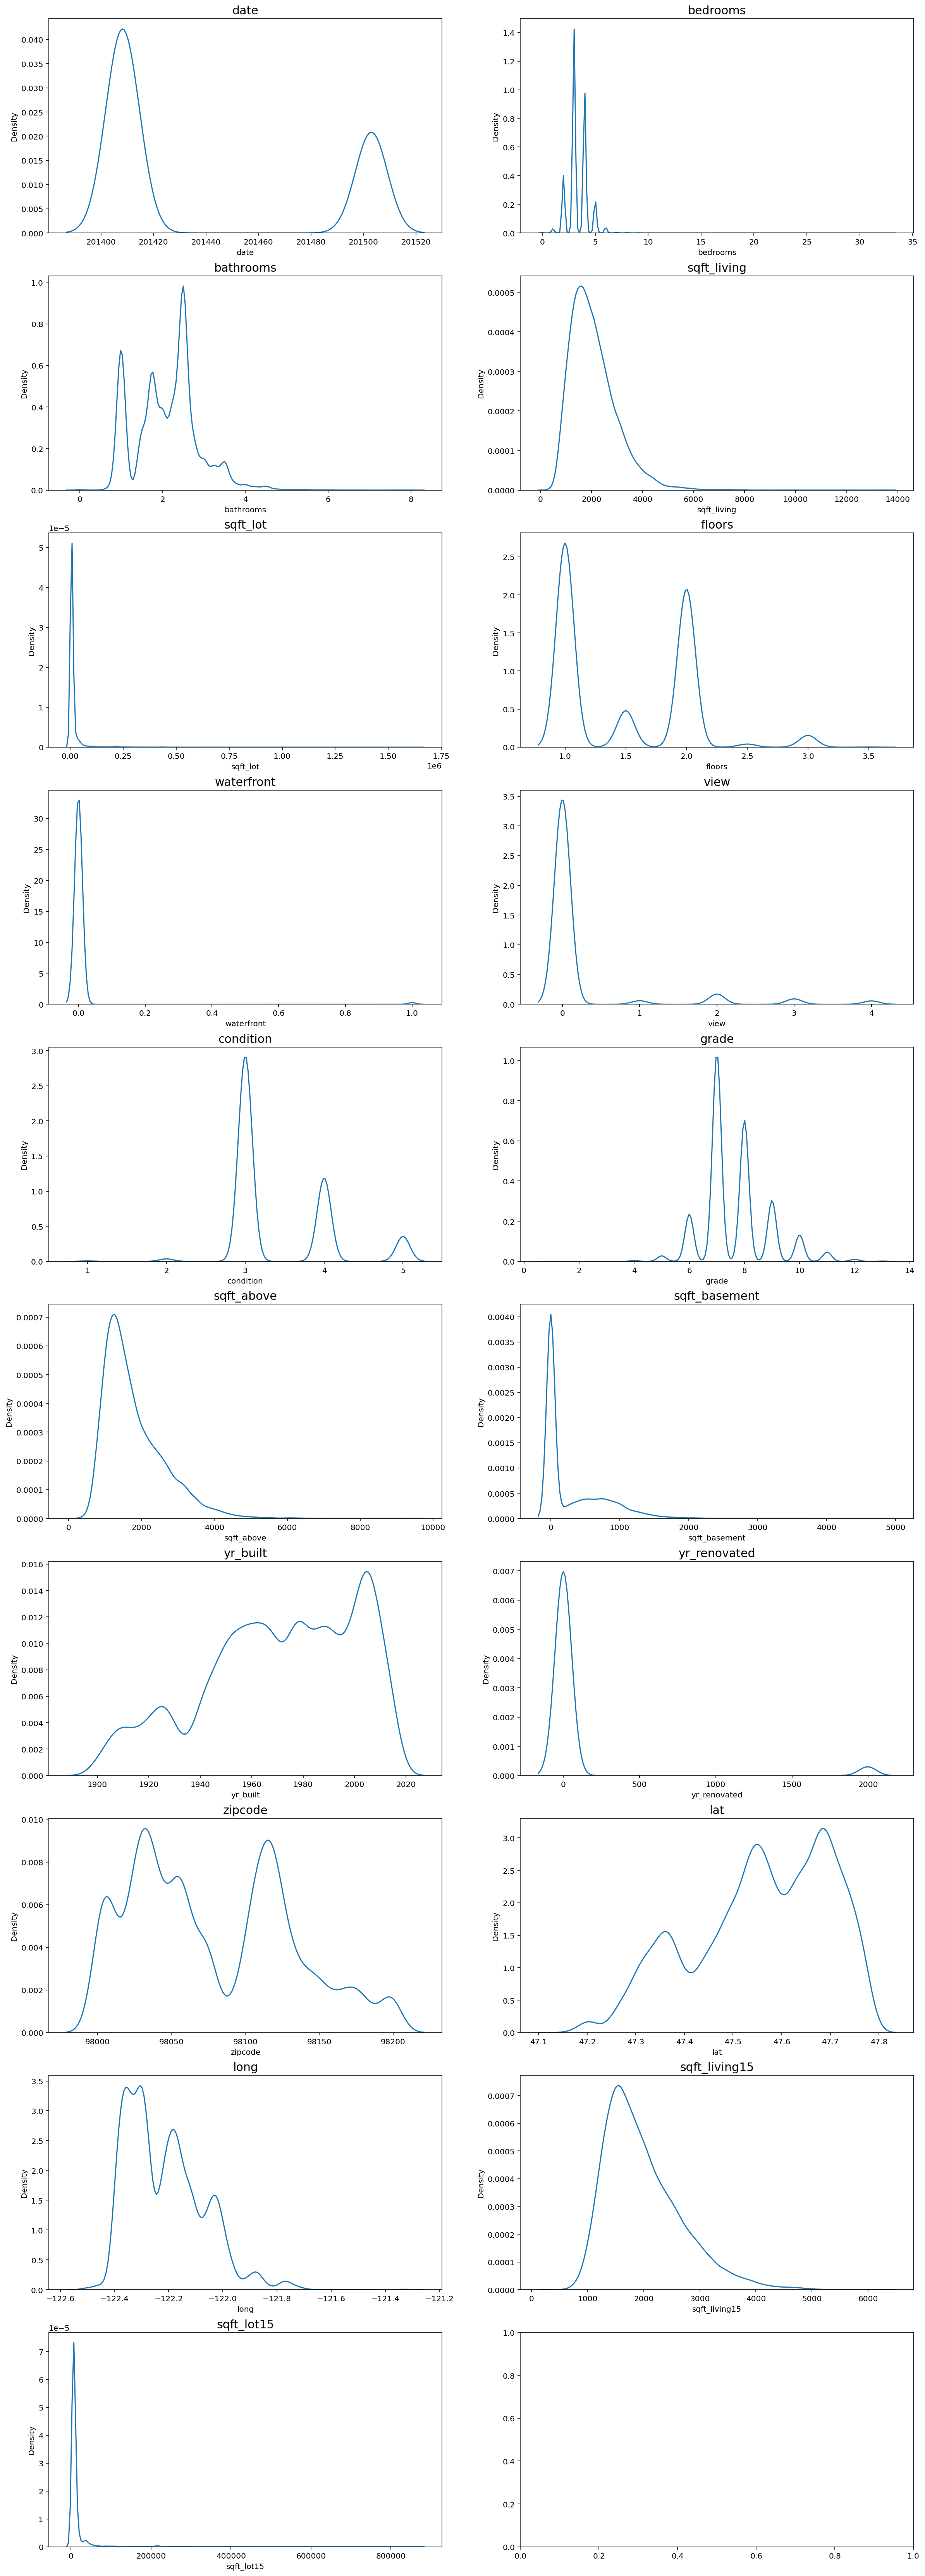

In [11]:
import seaborn as sns

fig, ax = plt.subplots(10, 2, figsize = (20, 60))

# 분포를 확인합니다. id를 이미 제거했기 때문에 0부터 세도 됨
count = 0
columns = data.columns

for row in range(10):
    for col in range(2):
        sns.kdeplot(data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19:
            break
            


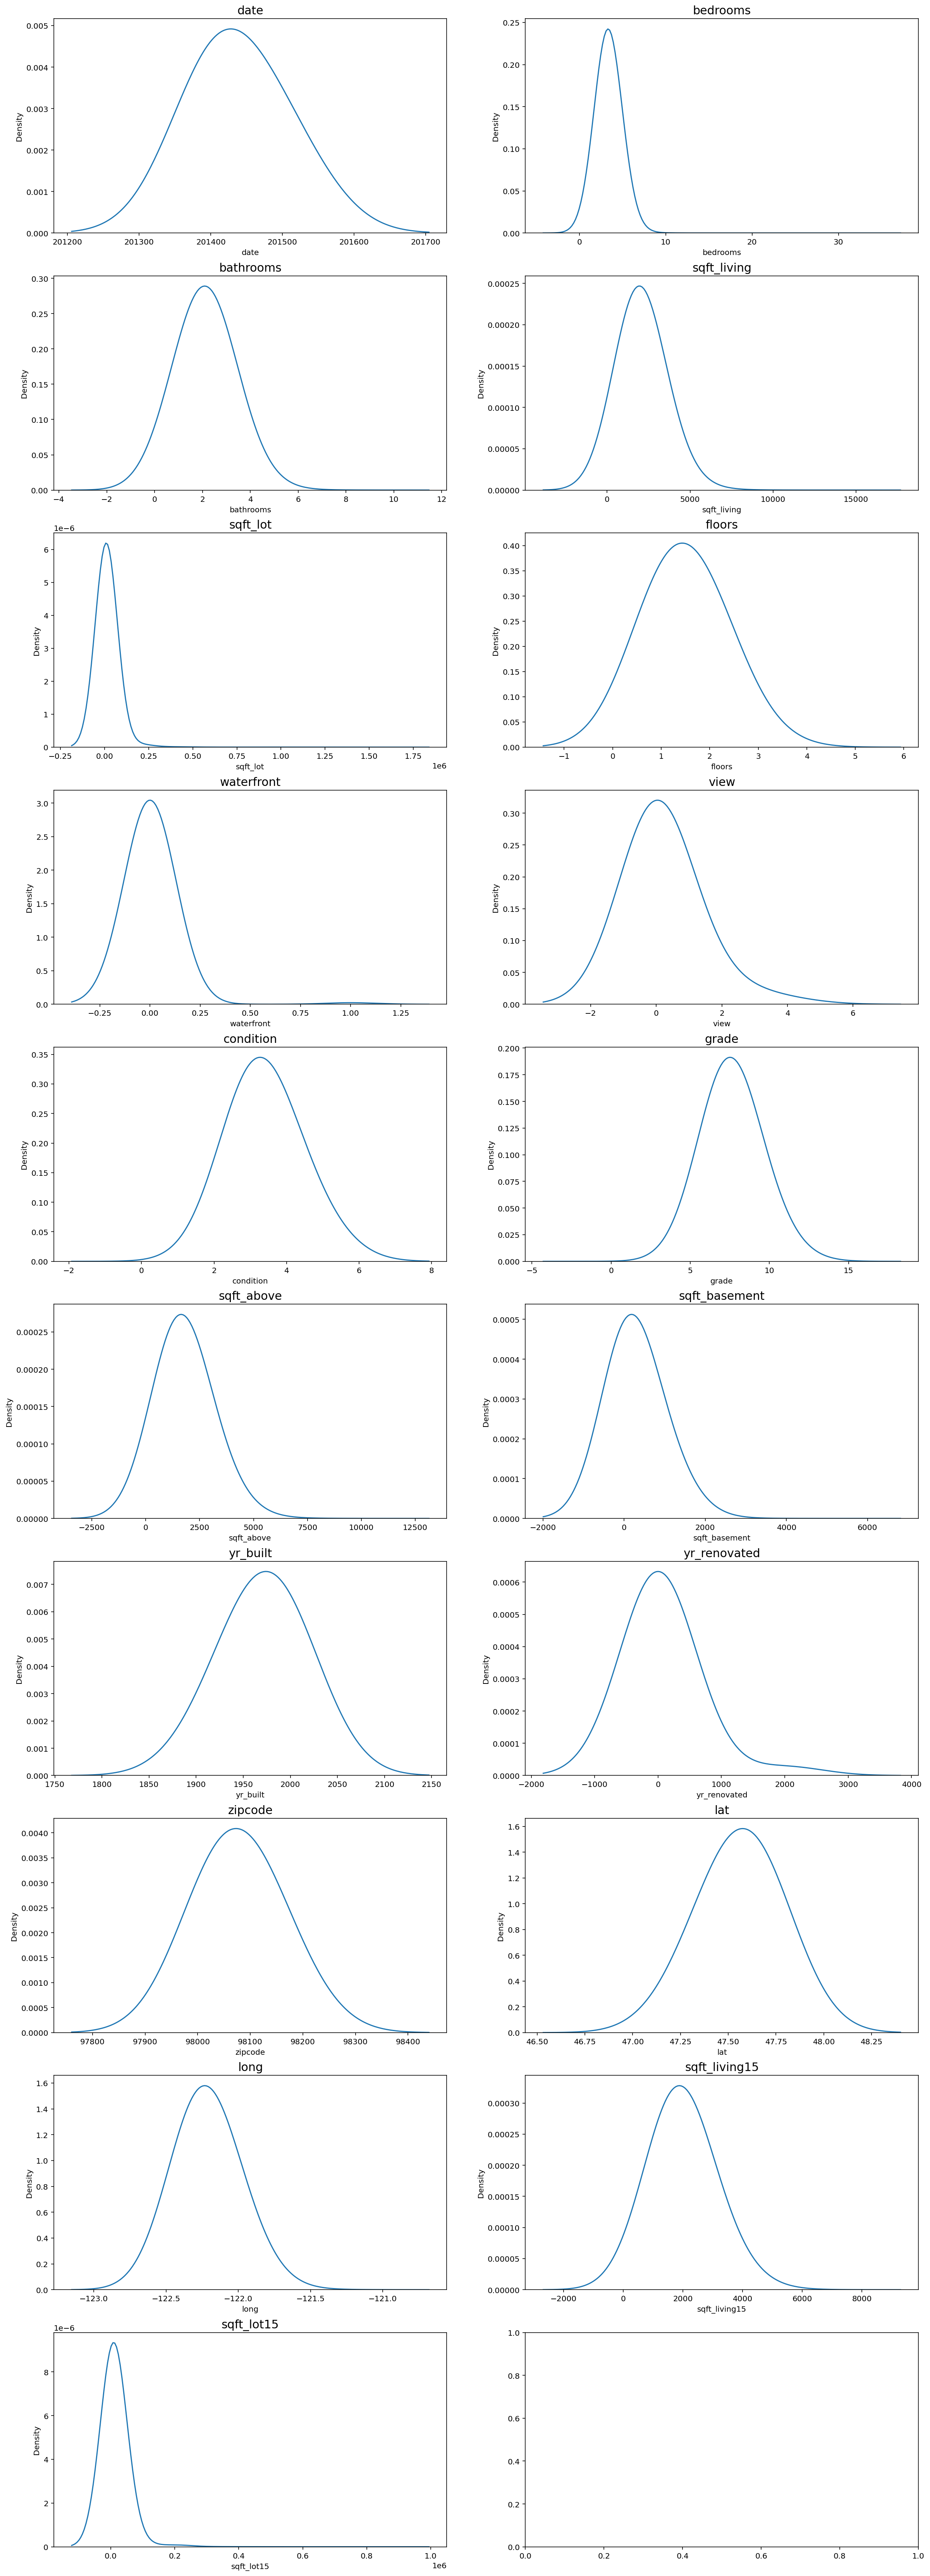

In [12]:
fig, ax = plt.subplots(10, 2, figsize = (20, 60))

count = 0
columns = data.columns

for row in range(10):
    for col in range(2):
        sns.kdeplot(data[columns[count]], bw = 1.5, ax=ax[row][col])   # bw를 넣으면 다른 그래프가 나오던데 뭔지 모르겠다.
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19:
            break
            


컬럼별로 보려고 함수 만들어봤어요

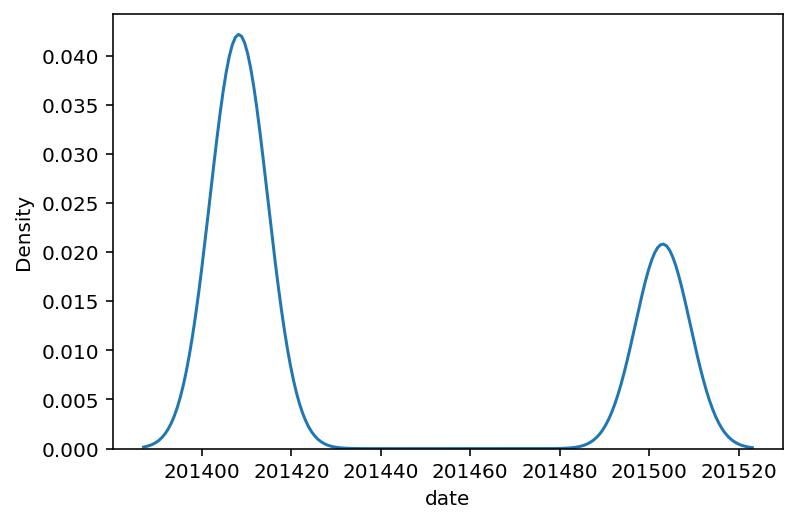

[201410 201502 201406 201501 201504 201405 201503 201407 201412 201408
 201411 201409 201505]


In [13]:
def 뿅(x):
    sns.kdeplot(data[x])
    plt.show()
    print(data[x].unique())
뿅('date')

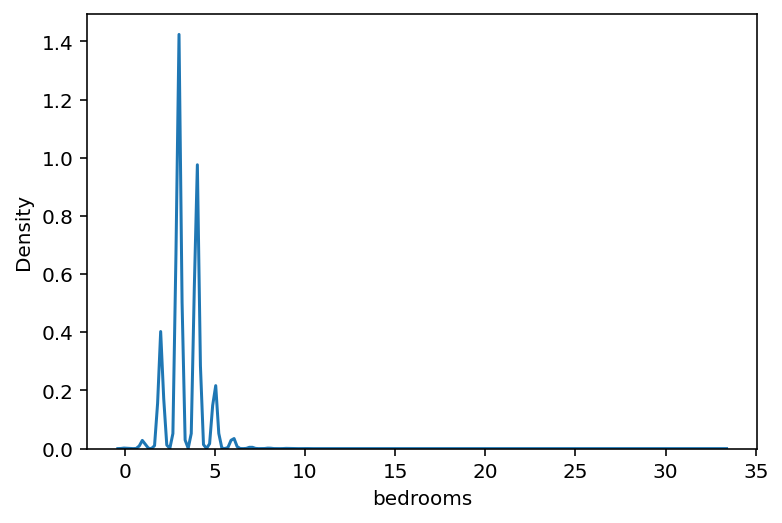

[ 3  2  5  4  6  1  7  9  8  0 10 11 33]


In [14]:
뿅('bedrooms')
# 방이 말도 안 되게 많은 애들이 있다. 집이 엄청난 대저택인건가....? 호구와트?

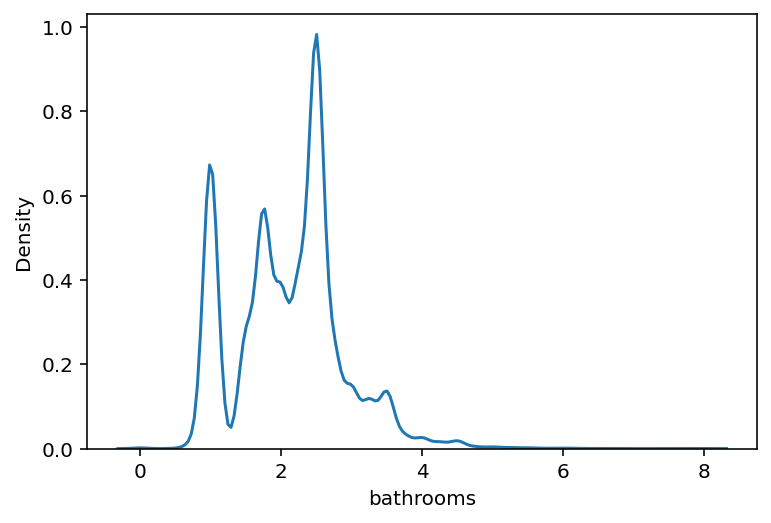

[1.   2.   2.25 1.5  2.5  1.75 3.   2.75 3.25 4.   3.5  0.75 4.75 5.
 4.25 4.5  3.75 5.25 6.   1.25 0.5  5.5  6.75 5.75 0.   8.   7.5  7.75
 6.25 6.5 ]


In [15]:
뿅('bathrooms')
# 정수가 아닌 이유는 미국의 기준에서 욕조가 존재해야만 하나의 bathroom으로 인정이 되기 때문이다.
# 세면대만 있는 경우, 욕조 없이 샤워부스만 있는 경우, (욕조 없이)변기가 있는 경우 모두 1 미만의 소수로 표현된다고 한다.
# 검색을 통해 봤었는데 며칠 전에 본거고 그때 어떻게 검색을 해서 찾았는지 기억나지 않는다.. 엉뚱한 것만 나오는...ㅠㅠ

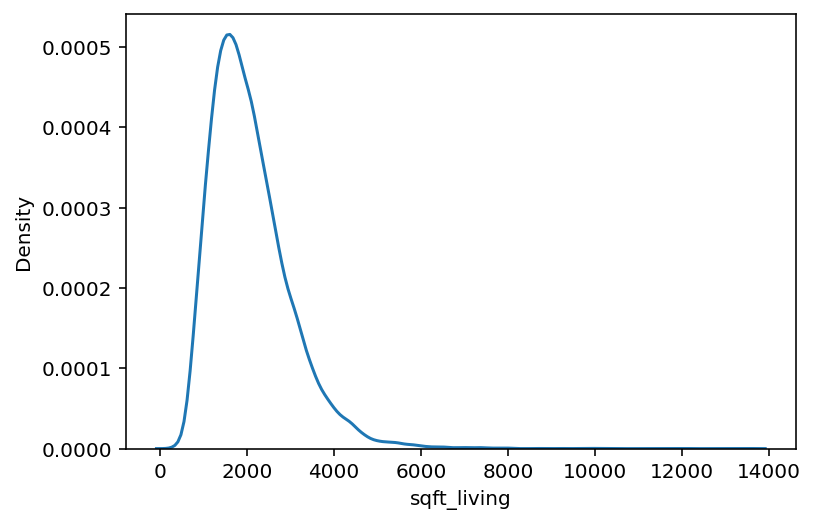

[1180  770 1680 ... 1496 7270 3118]


In [16]:
뿅('sqft_living')
# 겁나 넓은 집이 있어서 방이 많은 건가....?

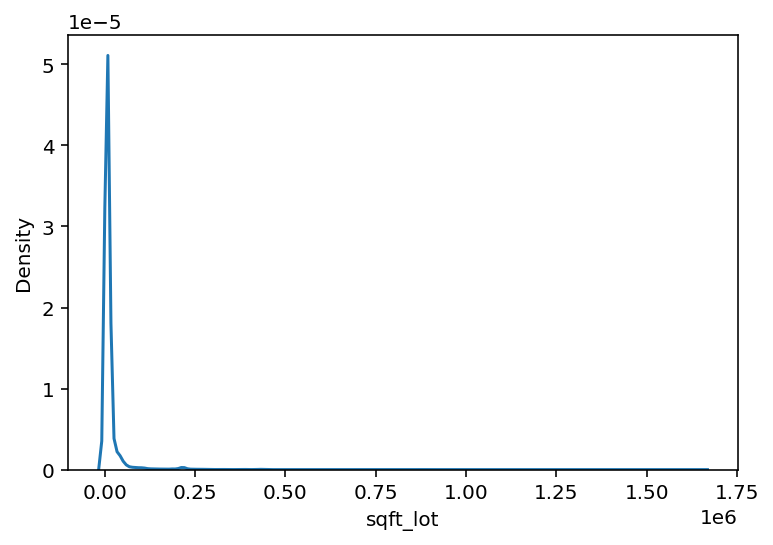

[ 5650 10000  8080 ... 11968  1126  2388]


In [17]:
뿅('sqft_lot')
# 주거면적과 부지면적은 15년 기준인 자료를 쓰고 지워버리는게 나을 것도 같다. 어차피 변하고 난 다음의 가격을 예측하는 거잖아...?

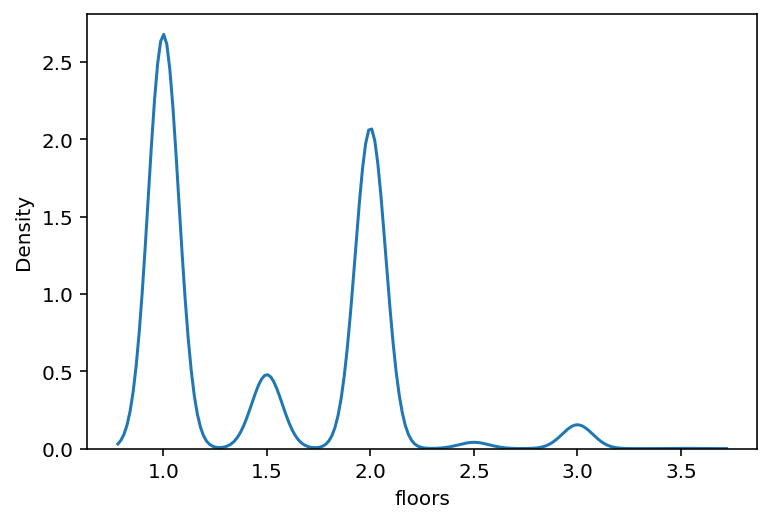

[1.  2.  1.5 3.  2.5 3.5]


In [18]:
뿅('floors')
# 소수점 뭐냐고..... 다락방인가

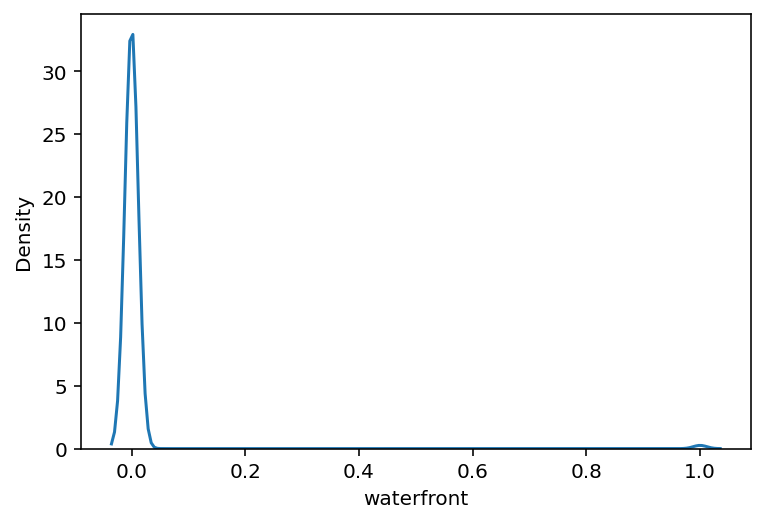

[0 1]


In [19]:
뿅('waterfront')
# 강변 유무라서 원핫인코딩인가보다

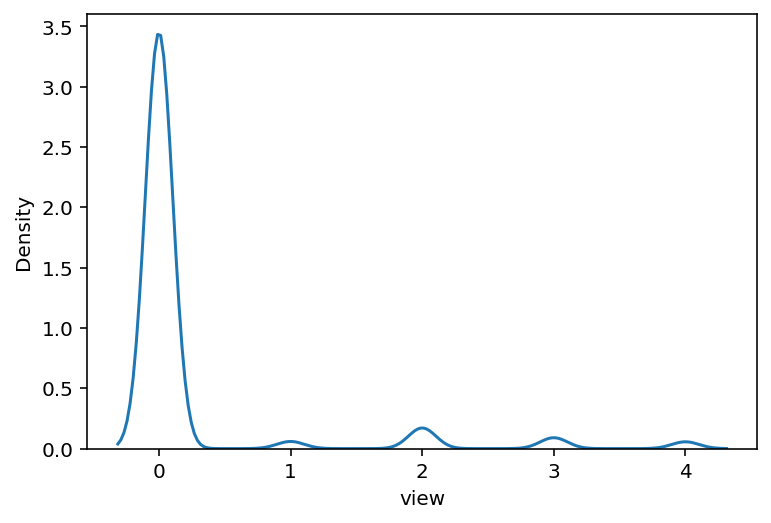

[0 3 4 2 1]


In [20]:
뿅('view')
# 얼마나 좋아보이는지를 수치로...? 낮을수록 좋은걸까 높을수록 좋은걸까
# 그래프를 보면 높은게 적으니까 높을수록 좋은 집이라는 것 같다.

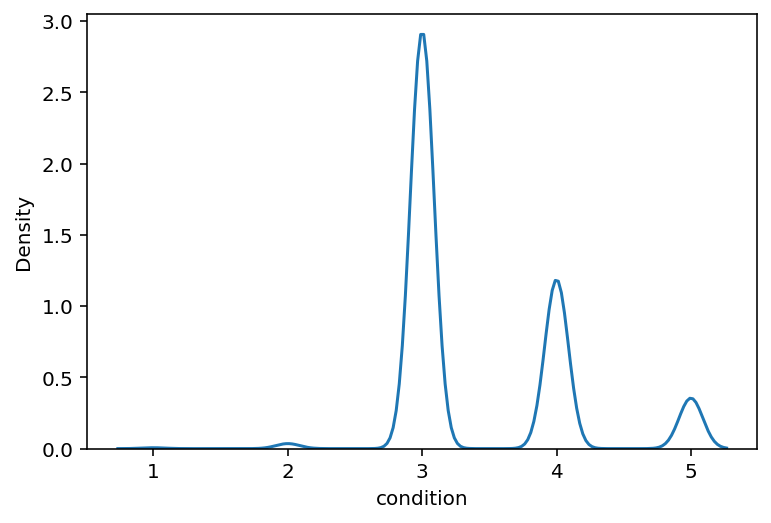

[3 4 5 2 1]


In [21]:
뿅('condition')
# 좋아보이나와 상태가 따로 있는건.... 흠... 이건 낡음의 정도일까

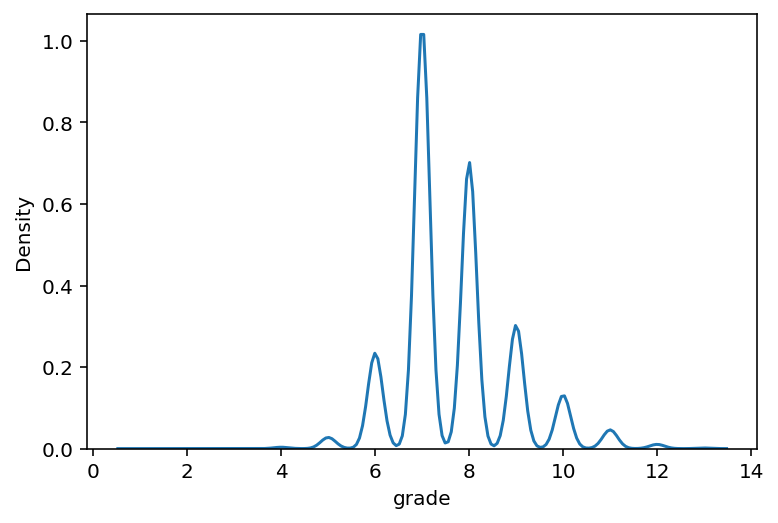

[ 7  6  8  9 10 11 12  5  4  3 13  1]


In [22]:
뿅('grade')
# 등급....

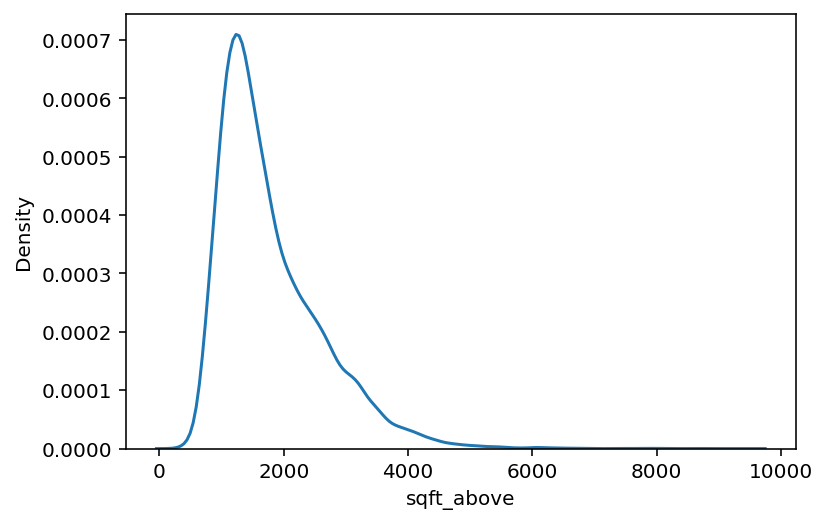

[1180  770 1680 1715 1060 1860  860 1430 1370 1810 1980 1890 1600 1200
 1250 2330 1070 2450 1710 1750 1400 2320 1510 1090 1280 2360  890 2620
 2600 3595 1570  990 2290 1000 2830 2250 2420 3250 1590 1260 1540 1110
 2720 2240 3070 2390  910 3450 2350 1900  960 2660  765 3520 1290 1960
 1160 1270 2190 1210 1240 3140 2310  700 1080 2520 2780  880 1560 1720
 1620 1360 1440 2140 1320 1010 1340 1190 1170  940 3670 3540 2500 1760
 1030 1780 3400 2680 1610 1670 2570 2590  820 1220 2440 1050 2090 1100
 1420 1690 1130 1910 1350 1940  900 1630 1550 2714 1870 1950 2020 1120
  980 1480 1230 2280 3760 1640 3530  830 1300  790 2740 1830  720 2010
 3360 2460 1460 1700 4750 5310  580 2653 2850 2630 3500 1740 1140 2160
 2270 2650 1330  970 2040 2220 1660 3370 2690  800 2050 2490 2560 1275
 2580 1390  560 2760 1820 1840 2990 1450 3230 1380 3030 2130 1580 3480
 2510 3300 3840 1530 2150 1930 2840  833 2000 6070  950 1770 2200 4040
 1920 1490 3130 2070 2610 3260 2260  430 3150 3390  850  630 3860 2810
 2380 

In [23]:
뿅('sqft_above')
# 지하실 제외면적
# 지하실이 따로 존재하니 제외면적은 지워도 되는 자료가 아닐까 싶다.

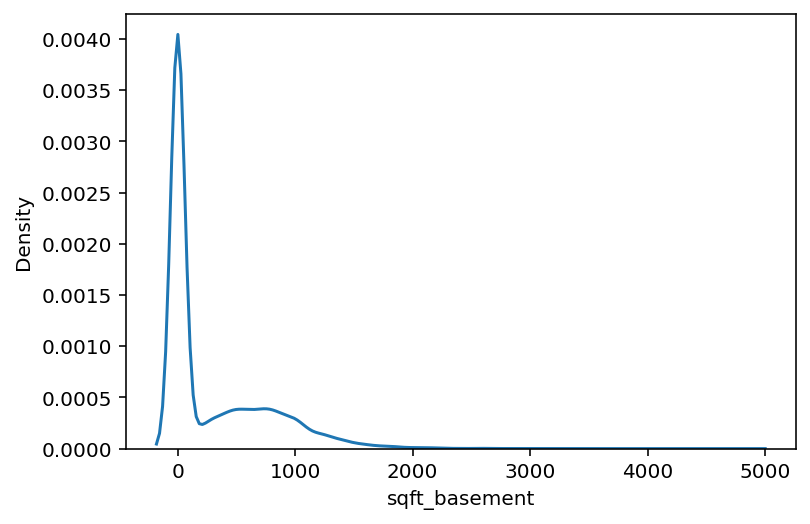

[   0 1700  300  970  760  720  700  820  780  790  330 1620  410  560
  550  500 1040  240  265  290  800  380 1000  710 1600  840  480  600
  570 1010 1250  120 1640 1460 1030  750  400  640 1070  490 1310  990
 2000  390  430  850  210 1430 1950  440  450  220  860  580 2060 1820
 1180  200  650 1150 1200  680  530 1170 1080 1100  280  870  620  460
  770 1400 1320  660  900 1580  180 1380  690  270  350  935 1370  980
 1130 1470  630  160  950   50  740 1780 1900  340  730  470 1450  370
  540  140 1760  610  880  890 1220 1020  520  150 1720  960  810  190
 1290  670 1510 1120 1110 1810   60 1050  940  310  930 1390  510  360
 1590  920 1270  420 1420 1240 1960 2020 2110 1490  250 1300 2390  170
  830 1280 1260  910  590 1160 1140  260  100  320 1190 1230 1060 1330
 1670 1350 2570 2590  110 1480 1410 2500   90 1550 2350 1340 1481 1360
 1135 1520 1660 2600  130 1690 2620 1798 1210 1610 1440 1500 1570  704
 1630 2360 1852 2090 2400 1790 2150  230 1090   70 3000 1870 1530 1710
 1650 

In [24]:
뿅('sqft_basement')
# 지하실 면적

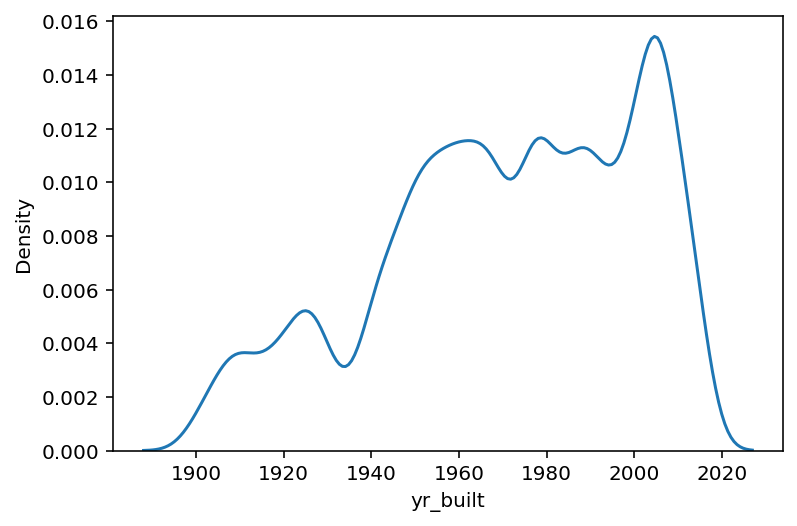

[1955 1933 1987 1995 1963 1965 1942 1927 1977 1900 1979 1994 1916 1921
 1969 1947 1968 1985 1941 1915 1909 2003 1929 1981 1930 1904 1996 1984
 2014 1922 1966 1950 2008 1959 1954 1989 2005 1973 1972 1986 1956 2002
 1992 1964 1952 1925 1961 2006 1988 2001 1962 1939 1967 1975 1910 1983
 1991 1905 1980 1971 2010 1945 1924 1978 1926 1923 1990 2000 1976 1949
 1999 1901 1993 1948 1920 1997 1957 2004 1960 1940 1918 1974 1911 1937
 1982 1908 1931 1998 1928 1943 1907 2013 1953 2012 2007 1912 2011 1917
 1958 1946 1951 1932 1944 2009 1903 1970 1938 1919 1906 1936 1913 1902
 1914 2015 1935 1934]


In [25]:
뿅('yr_built')
# 건축년

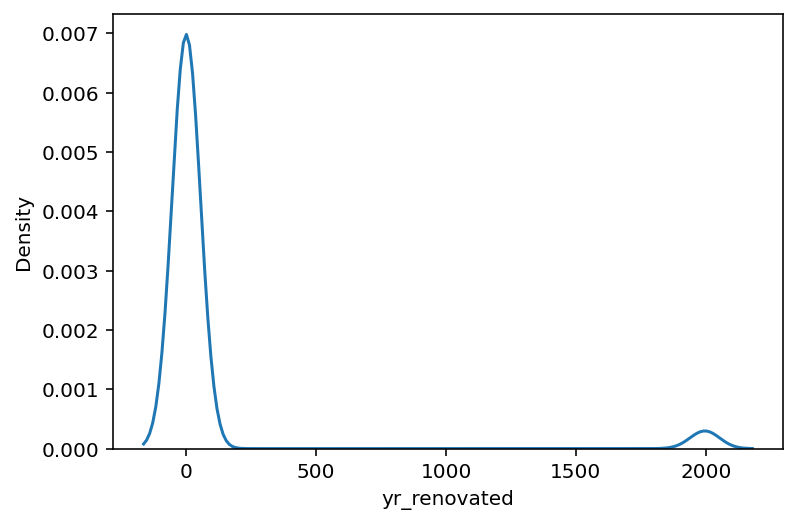

[   0 2002 1999 1991 1978 2005 2008 2003 1994 1984 1954 2014 2011 1974
 1983 2013 1990 1957 1977 1981 1995 2000 1986 1992 2004 2007 1987 2006
 1985 1971 1945 1979 1997 2010 1969 1948 2009 1970 2015 1989 2001 1968
 2012 1963 1993 1962 1972 1980 1998 1955 1996 1950 1956 1982 1988 1940
 1946 1975 1964 1958 1976 1973 1967 1965 1944 1951 1953 1959 1960 1934]


In [26]:
뿅('yr_renovated')
# 재건축년
# 0은 안한거.

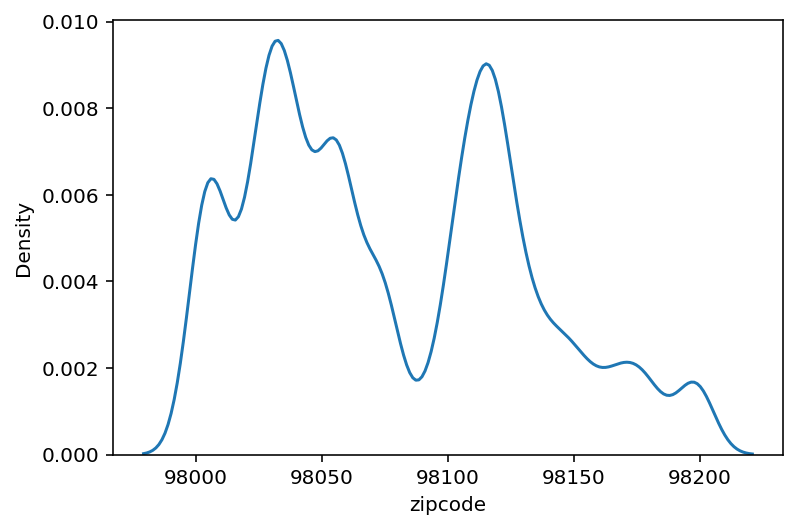

[98178 98028 98074 98003 98198 98007 98115 98107 98126 98019 98103 98002
 98133 98040 98030 98119 98112 98027 98117 98058 98001 98056 98166 98053
 98023 98105 98042 98008 98148 98122 98004 98005 98034 98125 98075 98010
 98038 98059 98092 98136 98199 98032 98045 98102 98077 98108 98168 98177
 98118 98006 98146 98033 98052 98155 98024 98116 98144 98011 98031 98106
 98065 98022 98070 98014 98055 98072 98029 98188 98109 98039]


In [27]:
# 우편번호.
뿅('zipcode')

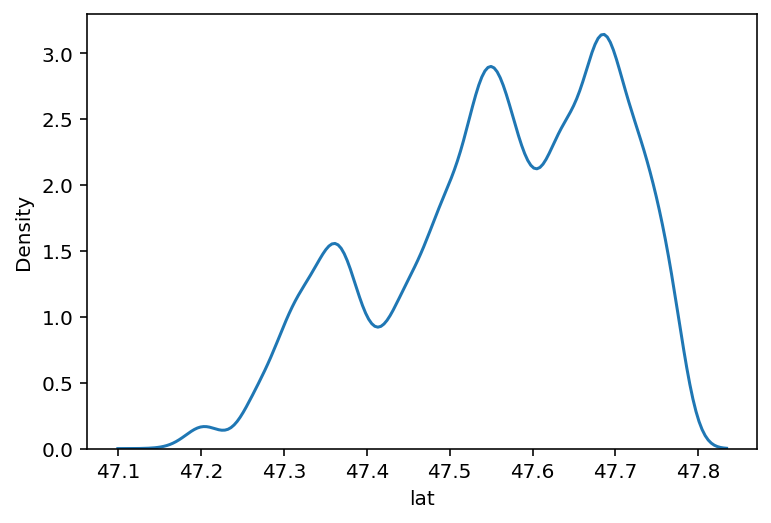

[47.5112 47.7379 47.6168 ... 47.2679 47.3562 47.2815]


In [28]:
뿅('lat')
# 우편번호가 있는데 위도 경도도 표시하는건 불필요 아닐까?

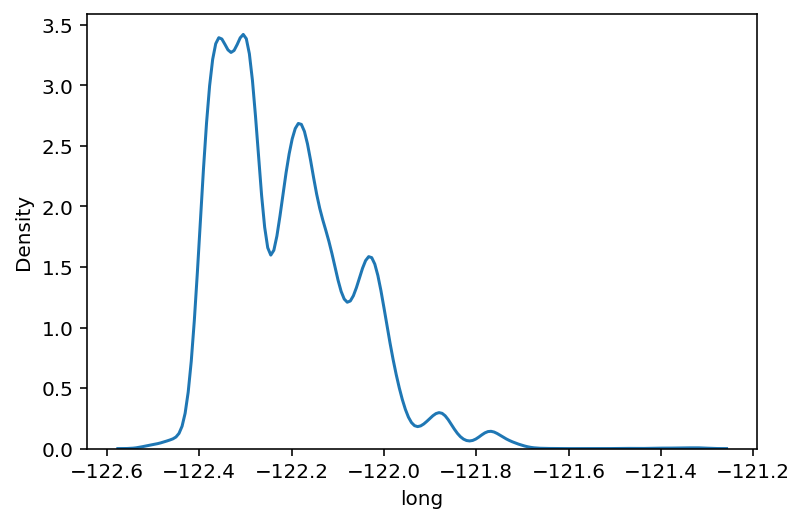

[-122.257 -122.233 -122.045 -122.327 -122.315 -122.145 -122.292 -122.229
 -122.394 -122.375 -121.962 -122.343 -122.21  -122.306 -122.341 -122.166
 -122.172 -122.218 -122.36  -122.314 -122.07  -122.368 -122.157 -122.31
 -122.362 -122.282 -122.18  -122.347 -122.016 -122.364 -122.371 -122.151
 -122.384 -122.29  -122.114 -122.122 -122.116 -122.339 -122.335 -122.32
 -122.297 -122.192 -122.11  -122.16  -122.179 -122.287 -122.073 -121.987
 -122.34  -122.025 -122.008 -122.031 -122.149 -122.365 -122.189 -122.387
 -122.372 -122.391 -122.351 -122.386 -122.277 -122.378 -121.714 -122.08
 -122.184 -122.322 -122.082 -122.053 -122.349 -122.295 -122.253 -122.248
 -122.303 -122.266 -122.244 -122.39  -122.352 -122.054 -122.38  -122.296
 -122.299 -122.381 -122.026 -122.353 -122.359 -122.162 -122.176 -122.118
 -122.193 -122.023 -122.224 -122.168 -122.125 -122.231 -122.331 -122.337
 -122.374 -122.182 -122.307 -122.358 -122.376 -122.2   -122.039 -122.102
 -122.188 -122.379 -122.043 -122.153 -122.191 -122.336

In [29]:
뿅('long')

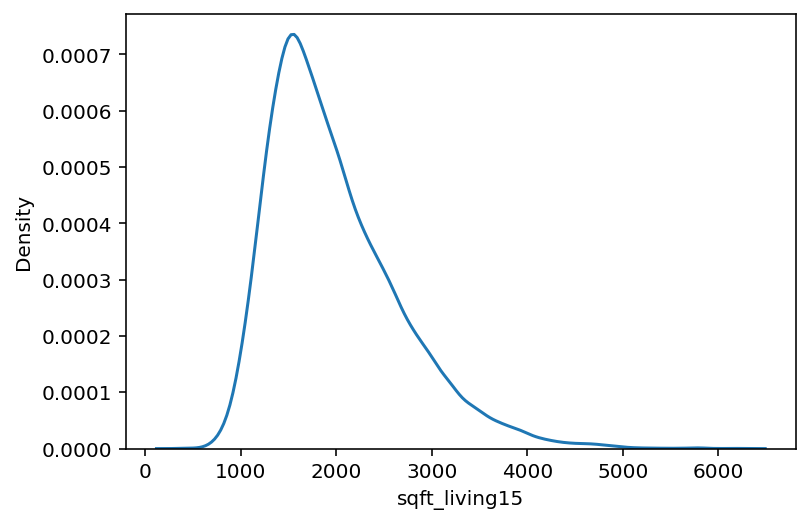

[1340 2720 1800 2238 1650 2210 1330 1780 1370 1360 2140 1890 1610 1060
 1280 1400 4110 1220 2200 1030 1760 1860 2580 1460 1570 2020 1590 1730
 1290 2620 2410 3625 1580 1228 2680 1410 1950 2250 2690 2960 2570 1440
 2750 2221 1010 3530 1640 1510 1940 3240 1130 3350 2350 1870 1850 1980
 2520 1350 1750 1160 2550 1270 2990 1380 1540 2090 2640 1830 1620 1190
 1880 2340 2660 1700 2060 1550 1560 2840 1500 1420 3160 1200 3400 1710
 2110 2920 2480 1770 1070 1930 1480 3740 2260 2290 1050 2540 2190 2030
 2230 1230 1900 2330 1680 1430 2770 1250 1630 2590 2130 3836 2120 1910
 2080 1960 2280 1150 3430 2070 2600  830 1260 1390 3120 2010 3060 1660
 1600 2380 1320 3890 4180 2653 3050 3920 1670 2320 2390 3150 2400 4550
 2510 2370 2440 2880 3860 2150 1310 1820 2500 1740  880 2560 3470 1020
 1720 2040 1300 2610 1520 2470 1810 2860 3480 3130 3360 2300 2420 4050
 2450 1450 1790 3180 3600 2000 2430 2850 4680 2310 3930 1490 2460 2077
 3630 3220 3230 2820 4300 3390 3080 2424 2530 1690 2160 2830 2900 2950
  940 

In [30]:
뿅('sqft_living15')
# 15년 기준 주거공간 재건축 이전과 이후가 다를 수 있어서 표기됨.

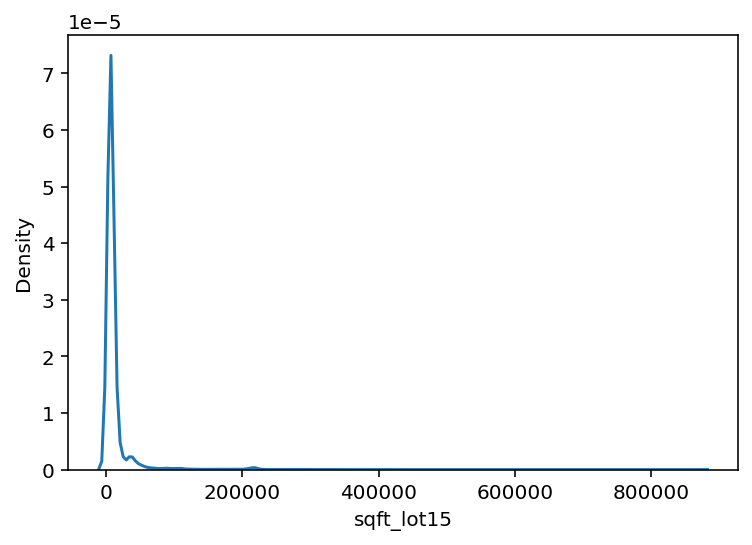

[ 5650  8062  7503 ... 18270 11303  2007]


In [31]:
뿅('sqft_lot15')
# 2015년 이후 전체부지

# 일단 필요 없어 보이는 자료들을 날려보자

In [32]:
del data['lat'] # data.drop(columns=[....], inplace=True)로 한번에 지울 수 있다.
del data['long'] # 우편번호로 어떤 위치에 집이 있는지 알 수 있으니 위도와 경도를 지웠다.
del data['sqft_above'] # 지하실 면적이 따로 존재하니 지하실제외면적을 지운다.
del data['sqft_lot']  # 과거의 면적이 필요하진 않아보인다. 타임머신 타고 과거로 가서 살 건 아니니까...?
del data['sqft_living'] 
data.head(10)

,date,bedrooms,bathrooms,floors,waterfront,view,condition,grade,sqft_basement,yr_built,yr_renovated,zipcode,sqft_living15,sqft_lot15
0,201410,3,1.00,1.0,0,0,3,7,0,1955,0,98178,1340,5650
1,201502,2,1.00,1.0,0,0,3,6,0,1933,0,98028,2720,8062
2,201502,3,2.00,1.0,0,0,3,8,0,1987,0,98074,1800,7503
3,201406,3,2.25,2.0,0,0,3,7,0,1995,0,98003,2238,6819
4,201501,3,1.50,1.0,0,0,3,7,0,1963,0,98198,1650,9711
5,201504,3,2.50,1.0,0,0,3,8,1700,1965,0,98007,2210,8925
6,201405,2,1.00,1.0,0,0,4,7,300,1942,0,98115,1330,6000
7,201405,3,1.00,1.5,0,0,4,7,0,1927,0,98028,1780,12697
8,201410,3,1.75,1.0,0,0,4,7,0,1977,0,98074,1370,10208
9,201503,5,2.00,1.5,0,0,3,7,0,1900,0,98107,1360,4850


# 재건축의 유무를 원핫인코딩으로

In [33]:
# 재건축 여부 
data['재건축여부'] = 0
data['재건축여부'] = np.where(data['yr_renovated'] != 0, 1, 0)
# 재건축 연도가 존재한다면 1을 표기하고, 없다면 0을 표기

In [34]:
data.head(10)

,date,bedrooms,bathrooms,floors,waterfront,view,condition,grade,sqft_basement,yr_built,yr_renovated,zipcode,sqft_living15,sqft_lot15,재건축여부
0,201410,3,1.00,1.0,0,0,3,7,0,1955,0,98178,1340,5650,0
1,201502,2,1.00,1.0,0,0,3,6,0,1933,0,98028,2720,8062,0
2,201502,3,2.00,1.0,0,0,3,8,0,1987,0,98074,1800,7503,0
3,201406,3,2.25,2.0,0,0,3,7,0,1995,0,98003,2238,6819,0
4,201501,3,1.50,1.0,0,0,3,7,0,1963,0,98198,1650,9711,0
5,201504,3,2.50,1.0,0,0,3,8,1700,1965,0,98007,2210,8925,0
6,201405,2,1.00,1.0,0,0,4,7,300,1942,0,98115,1330,6000,0
7,201405,3,1.00,1.5,0,0,4,7,0,1927,0,98028,1780,12697,0
8,201410,3,1.75,1.0,0,0,4,7,0,1977,0,98074,1370,10208,0
9,201503,5,2.00,1.5,0,0,3,7,0,1900,0,98107,1360,4850,0


# 컨디션, 뷰, 그레이드를 상태에 따른 원핫코딩 여러 컬럼으로 나누기

In [35]:
conditions = pd.get_dummies(data['condition'], prefix = "condition_")
conditions

,condition__1,condition__2,condition__3,condition__4,condition__5
0,0,0,1,0,0
1,0,0,1,0,0
2,0,0,1,0,0
3,0,0,1,0,0
4,0,0,1,0,0
...,...,...,...,...,...
6463,0,0,1,0,0
6464,0,0,1,0,0
6465,0,0,1,0,0
6466,0,0,1,0,0


In [36]:
views = pd.get_dummies(data['view'], prefix = "view_")
views

,view__0,view__1,view__2,view__3,view__4
0,1,0,0,0,0
1,1,0,0,0,0
2,1,0,0,0,0
3,1,0,0,0,0
4,1,0,0,0,0
...,...,...,...,...,...
6463,1,0,0,0,0
6464,1,0,0,0,0
6465,1,0,0,0,0
6466,1,0,0,0,0


In [37]:
grades = pd.get_dummies(data['grade'], prefix = "grade_")
grades

,grade__1,grade__3,grade__4,grade__5,grade__6,grade__7,grade__8,grade__9,grade__10,grade__11,grade__12,grade__13
0,0,0,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
6463,0,0,0,0,1,0,0,0,0,0,0,0
6464,0,0,0,0,0,0,1,0,0,0,0,0
6465,0,0,0,0,0,0,1,0,0,0,0,0
6466,0,0,0,0,0,1,0,0,0,0,0,0


그레이드에 2급이 빠져서 추가해주기

In [38]:
grades['grade__2'] = 0
grades

,grade__1,grade__3,grade__4,grade__5,grade__6,grade__7,grade__8,grade__9,grade__10,grade__11,grade__12,grade__13,grade__2
0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6463,0,0,0,0,1,0,0,0,0,0,0,0,0
6464,0,0,0,0,0,0,1,0,0,0,0,0,0
6465,0,0,0,0,0,0,1,0,0,0,0,0,0
6466,0,0,0,0,0,1,0,0,0,0,0,0,0


In [39]:
grades.columns

Index(['grade__1', 'grade__3', 'grade__4', 'grade__5', 'grade__6', 'grade__7',
       'grade__8', 'grade__9', 'grade__10', 'grade__11', 'grade__12',
       'grade__13', 'grade__2'],
      dtype='object')

In [40]:
# 컬럼 순서를 바꿔주고싶어서
grades = grades[['grade__1', 'grade__2', 'grade__3', 'grade__4', 'grade__5', 'grade__6', 'grade__7',
       'grade__8', 'grade__9', 'grade__10', 'grade__11', 'grade__12',
       'grade__13']]
grades

,grade__1,grade__2,grade__3,grade__4,grade__5,grade__6,grade__7,grade__8,grade__9,grade__10,grade__11,grade__12,grade__13
0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6463,0,0,0,0,0,1,0,0,0,0,0,0,0
6464,0,0,0,0,0,0,0,1,0,0,0,0,0
6465,0,0,0,0,0,0,0,1,0,0,0,0,0
6466,0,0,0,0,0,0,1,0,0,0,0,0,0


In [41]:
grades.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21503 entries, 0 to 6467
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   grade__1   21503 non-null  uint8
 1   grade__2   21503 non-null  int64
 2   grade__3   21503 non-null  uint8
 3   grade__4   21503 non-null  uint8
 4   grade__5   21503 non-null  uint8
 5   grade__6   21503 non-null  uint8
 6   grade__7   21503 non-null  uint8
 7   grade__8   21503 non-null  uint8
 8   grade__9   21503 non-null  uint8
 9   grade__10  21503 non-null  uint8
 10  grade__11  21503 non-null  uint8
 11  grade__12  21503 non-null  uint8
 12  grade__13  21503 non-null  uint8
dtypes: int64(1), uint8(12)
memory usage: 588.0 KB


In [42]:
# 추가한 2번만 자료형이 다르니 같은걸로 맞춰주기
grades = grades.astype({'grade__2': 'uint8'})
grades.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21503 entries, 0 to 6467
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   grade__1   21503 non-null  uint8
 1   grade__2   21503 non-null  uint8
 2   grade__3   21503 non-null  uint8
 3   grade__4   21503 non-null  uint8
 4   grade__5   21503 non-null  uint8
 5   grade__6   21503 non-null  uint8
 6   grade__7   21503 non-null  uint8
 7   grade__8   21503 non-null  uint8
 8   grade__9   21503 non-null  uint8
 9   grade__10  21503 non-null  uint8
 10  grade__11  21503 non-null  uint8
 11  grade__12  21503 non-null  uint8
 12  grade__13  21503 non-null  uint8
dtypes: uint8(13)
memory usage: 441.0 KB


In [43]:
data.head(10)

,date,bedrooms,bathrooms,floors,waterfront,view,condition,grade,sqft_basement,yr_built,yr_renovated,zipcode,sqft_living15,sqft_lot15,재건축여부
0,201410,3,1.00,1.0,0,0,3,7,0,1955,0,98178,1340,5650,0
1,201502,2,1.00,1.0,0,0,3,6,0,1933,0,98028,2720,8062,0
2,201502,3,2.00,1.0,0,0,3,8,0,1987,0,98074,1800,7503,0
3,201406,3,2.25,2.0,0,0,3,7,0,1995,0,98003,2238,6819,0
4,201501,3,1.50,1.0,0,0,3,7,0,1963,0,98198,1650,9711,0
5,201504,3,2.50,1.0,0,0,3,8,1700,1965,0,98007,2210,8925,0
6,201405,2,1.00,1.0,0,0,4,7,300,1942,0,98115,1330,6000,0
7,201405,3,1.00,1.5,0,0,4,7,0,1927,0,98028,1780,12697,0
8,201410,3,1.75,1.0,0,0,4,7,0,1977,0,98074,1370,10208,0
9,201503,5,2.00,1.5,0,0,3,7,0,1900,0,98107,1360,4850,0


In [44]:
data = pd.concat([data, conditions, views, grades], axis=1)
data.head()

,date,bedrooms,bathrooms,floors,waterfront,view,condition,grade,sqft_basement,yr_built,...,grade__4,grade__5,grade__6,grade__7,grade__8,grade__9,grade__10,grade__11,grade__12,grade__13
0,201410,3,1.00,1.0,0,0,3,7,0,1955,...,0,0,0,1,0,0,0,0,0,0
1,201502,2,1.00,1.0,0,0,3,6,0,1933,...,0,0,1,0,0,0,0,0,0,0
2,201502,3,2.00,1.0,0,0,3,8,0,1987,...,0,0,0,0,1,0,0,0,0,0
3,201406,3,2.25,2.0,0,0,3,7,0,1995,...,0,0,0,1,0,0,0,0,0,0
4,201501,3,1.50,1.0,0,0,3,7,0,1963,...,0,0,0,1,0,0,0,0,0,0


In [45]:
# 잘게 쪼개서 반영했으니 원래 컬럼들은 삭제해버리기
data.drop(columns=['condition', 'view', 'grade'], inplace=True)
data.columns

Index(['date', 'bedrooms', 'bathrooms', 'floors', 'waterfront',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'sqft_living15',
       'sqft_lot15', '재건축여부', 'condition__1', 'condition__2', 'condition__3',
       'condition__4', 'condition__5', 'view__0', 'view__1', 'view__2',
       'view__3', 'view__4', 'grade__1', 'grade__2', 'grade__3', 'grade__4',
       'grade__5', 'grade__6', 'grade__7', 'grade__8', 'grade__9', 'grade__10',
       'grade__11', 'grade__12', 'grade__13'],
      dtype='object')

In [46]:
data.head()

,date,bedrooms,bathrooms,floors,waterfront,sqft_basement,yr_built,yr_renovated,zipcode,sqft_living15,...,grade__4,grade__5,grade__6,grade__7,grade__8,grade__9,grade__10,grade__11,grade__12,grade__13
0,201410,3,1.00,1.0,0,0,1955,0,98178,1340,...,0,0,0,1,0,0,0,0,0,0
1,201502,2,1.00,1.0,0,0,1933,0,98028,2720,...,0,0,1,0,0,0,0,0,0,0
2,201502,3,2.00,1.0,0,0,1987,0,98074,1800,...,0,0,0,0,1,0,0,0,0,0
3,201406,3,2.25,2.0,0,0,1995,0,98003,2238,...,0,0,0,1,0,0,0,0,0,0
4,201501,3,1.50,1.0,0,0,1963,0,98198,1650,...,0,0,0,1,0,0,0,0,0,0


참고한 자료에서는 데이터를 직접적으로 조정하는 경우가 있었는데 확신이 없는 이상 그래선 안 되는 것 같아서 따라하진 않을 생각이다.  
또한 욕실이나 침실을 정규화하는 경우도 따라하지 않을 생각이다. 그건 그 숫자 자체가 의미있어 보여서....ㅇㅅㅇ;

In [47]:
# 정규화
skew_columns = ['sqft_basement', 'sqft_living15', 'sqft_lot15']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

In [48]:
data.head()

,date,bedrooms,bathrooms,floors,waterfront,sqft_basement,yr_built,yr_renovated,zipcode,sqft_living15,...,grade__4,grade__5,grade__6,grade__7,grade__8,grade__9,grade__10,grade__11,grade__12,grade__13
0,201410,3,1.00,1.0,0,0.0,1955,0,98178,7.201171,...,0,0,0,1,0,0,0,0,0,0
1,201502,2,1.00,1.0,0,0.0,1933,0,98028,7.908755,...,0,0,1,0,0,0,0,0,0,0
2,201502,3,2.00,1.0,0,0.0,1987,0,98074,7.496097,...,0,0,0,0,1,0,0,0,0,0
3,201406,3,2.25,2.0,0,0.0,1995,0,98003,7.713785,...,0,0,0,1,0,0,0,0,0,0
4,201501,3,1.50,1.0,0,0.0,1963,0,98198,7.409136,...,0,0,0,1,0,0,0,0,0,0


가격

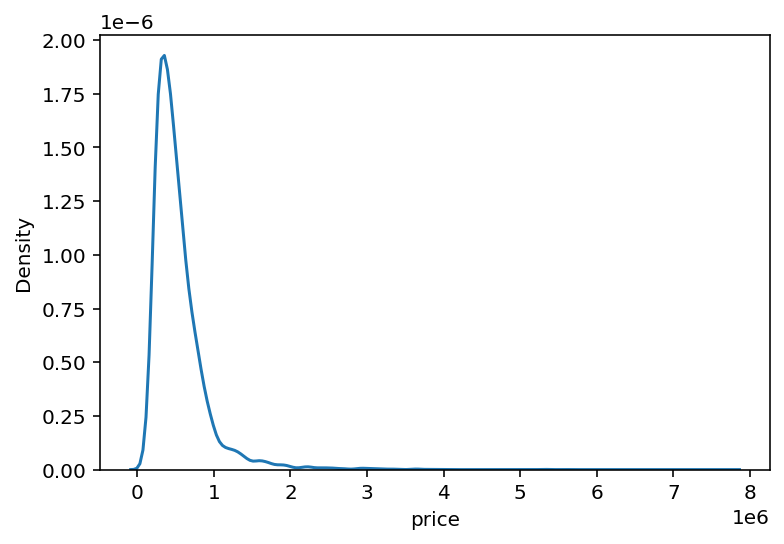

In [49]:
sns.kdeplot(y)
plt.show()

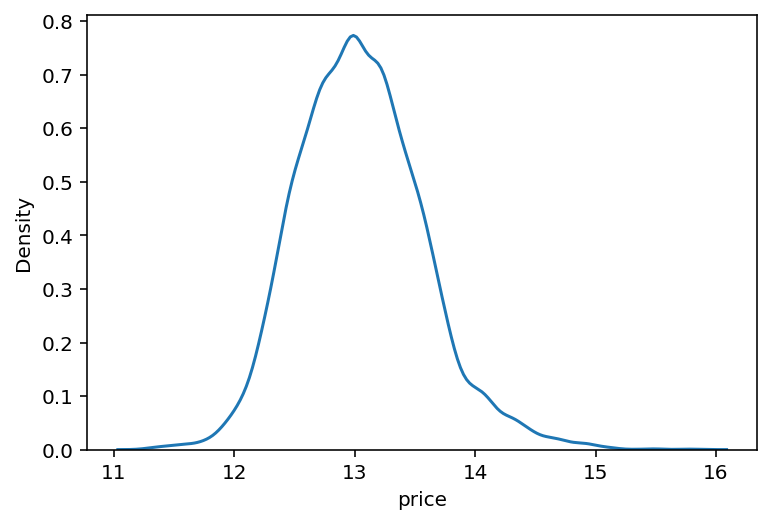

In [50]:
#로그
y_log_transformation = np.log1p(y)

sns.kdeplot(y_log_transformation)
plt.show()

데이터 분리  
위에서 저장해두었던 train_len을 인덱스로 활용해서 :train_len까지는 학습 데이터, 즉 x에 저장하고  
train_len: 부터는 실제로 추론을 해야 하는 테스트 데이터, 즉 sub 변수에 저장

In [51]:
sub = data.iloc[train_len:, :]
x = data.iloc[:train_len, :]

print(x.shape)
print(sub.shape)

(15035, 35)
(6468, 35)


모델

In [52]:
gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(random_state=2019)
lightgbm = lgb.LGBMRegressor(random_state=2019)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

print('얍💢')

얍💢


In [53]:
def get_cv_score(models):
    kfold = KFold(n_splits=5, shuffle=True, random_state=2019).get_n_splits(x.values)
    for m in models:
        print("Model {} CV score : {:.4f}".format(m['name'], np.mean(cross_val_score(m['model'], x.values, y)), 
                                                  kf=kfold))
print('얍💢')

얍💢


In [54]:
get_cv_score(models)

Model GradientBoosting CV score : 0.7459
Model XGBoost CV score : 0.7904
Model LightGBM CV score : 0.7844


In [55]:
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

print('얍💢')

얍💢


In [56]:
y_pred = AveragingBlending(models, x, y, sub)
print(len(y_pred))
y_pred

6468


array([ 468213.30733891,  485844.28175166, 1357393.7145277 , ...,
        440252.15675077,  315445.67671757,  383766.71155516])

In [57]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [58]:
result = pd.DataFrame({
    'id' : sub_id, 
    'price' : y_pred
})

result.head()

,id,price
0,15035,4.682133e+05
1,15036,4.858443e+05
2,15037,1.357394e+06
3,15038,3.402378e+05
4,15039,3.687370e+05


In [59]:
my_submission_path = join(data_dir, 'submission.csv')
result.to_csv(my_submission_path, index=False)

print(my_submission_path)

/aiffel/aiffel/kaggle_kakr_housing/data/submission.csv


망했다.ㅋㅋㅋㅋㅋ12만점....ㅇㅅㅇ